


<font size='10' color = 'E3A440'>**Mégadonnées et techniques avancées démystifiées**</font>
=======
<font color = 'E3A440'>*Nouvelles méthodes d’analyse et leur implication quant à la gestion des mégadonnées en SSH (partie 2)*</font>
=============


Cet atelier s’inscrit dans le cadre de la formation [Mégadonnées et techniques avancées démystifiées](https://www.4point0.ca/2022/08/22/formation-megadonnees-demystifiees/) (séance 6).

Les sciences humaines et sociales sont souvent confrontées à l’analyse de données non structurées, comme le texte. Après avoir préparé les données, plusieurs techniques d’analyse venant de l’apprentissage automatique peuvent être utilisées. Pendant cet atelier, les participants seront initiés au prétraitement des données textuelles et aux méthodes supervisées et non supervisées à des buts d’analyse avec Python.

Structure de l'atelier :
1. Partie 1 : à revoir

### Auteurs: 
- Bruno Agard <bruno.agard@polymtl.ca>
- Davide Pulizzotto <davide.pulizzotto@polymtl.ca>

Département de Mathématiques et de génie industriel

École Polytechnique de Montréal

# <font color = 'E3A440'>0. Préparation de l'environnement </font>

In [1]:
# Downloading of data from the GitHub project
#!rm -rf Data_techniques_demystified_webinars/
!rm -rf Donnees_demystifiees_seance_6/
#!git clone https://github.com/4point0-ChairInnovation-Polymtl/Data_techniques_demystified_webinars
!git clone https://github.com/puli83/Donnees_demystifiees_seance_6

Cloning into 'Donnees_demystifiees_seance_6'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 132 (delta 20), reused 0 (delta 0), pack-reused 94
Receiving objects: 100% (132/132), 46.92 MiB | 41.78 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [2]:
# Import modules
import os
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

# <font color = 'E3A440'>1. Prétraitement du corpus (rappels)</font>

Le prétraitement d'un corpus de textes peut nécessiter la mise en place de plusieurs étapes dont : le découpage des phrases, des mots, le nettoyage, le filtrage, etc.

Dans les prochains blocs de code, un texte sera segmenté en phrases et pratraité au moyen de la fonction `CleaningText()`.


In [3]:
text = """At eight o'clock, on Thursday morning, the great Arthur didn't feel VERY good.
The following morning, at nine, Arthur felt better.
A dog runs in the street.
A little boy runs in the street.
Arthur is my dog, he sleeps every morning."""

In [4]:
# extraction des phrases
sentences = nltk.sent_tokenize(text)
print(sentences)

["At eight o'clock, on Thursday morning, the great Arthur didn't feel VERY good.", 'The following morning, at nine, Arthur felt better.', 'A dog runs in the street.', 'A little boy runs in the street.', 'Arthur is my dog, he sleeps every morning.']


In [5]:
# Cleaning fonction to preprocess text
def CleaningText(text_as_string, language = 'english', reduce = '', list_pos_to_keep = [], Stopwords_to_add = []):
    from nltk.corpus import stopwords

    words = nltk.word_tokenize(text_as_string)
    words_pos = nltk.pos_tag(words, tagset='universal')
    words_pos = [(w, pos) for w, pos in words_pos if w.isalnum()]
    words_pos = [(w.lower(), pos) for w, pos in words_pos]
    
    if reduce == 'stem': 
        from nltk.stem.porter import PorterStemmer
        reduced_words_pos = [(PorterStemmer().stem(w), pos) for w, pos in words_pos]
        
    elif reduce == 'lemma':
        from nltk.stem.wordnet import WordNetLemmatizer
        reduced_words_pos = [(WordNetLemmatizer().lemmatize(w), pos) for w, pos in words_pos]
    else:
        import warnings
        reduced_words_pos = words_pos
        warnings.warn("Warning : any reduction was made on words! Please, use \"reduce\" argument to chosse between 'stem' or  'lemma'")
    if list_pos_to_keep:
        reduced_words_pos = [(w, pos) for w, pos in reduced_words_pos if pos in list_pos_to_keep]
    else:
        import warnings
        warnings.warn("Warning : any POS filtering was made. Please, use \"list_pos_to_keep\" to create a list of POS tag to keep.")
    
    list_stopwords = stopwords.words(language) + Stopwords_to_add
    reduced_words_pos = [(w, pos) for w, pos in reduced_words_pos if w not in list_stopwords and len(w) > 1 ]
    return reduced_words_pos

# Draw fonction for ploit results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import unique
from numpy import where

def draw(X,yhat):
    # retrieve unique clusters
    clusters = unique(yhat)

    #plt.figure(figsize=(10, 10))
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1])

    plt.title("Clusters")
    # show the plot
    plt.show()    

In [60]:
# nettoyage des phrases, sélection de pos-tag
cleaned_sentences = [CleaningText(sent, reduce = 'lemma', list_pos_to_keep = ['NOUN','ADJ','VERB']) for sent in sentences]
print(cleaned_sentences)

[[('thursday', 'NOUN'), ('morning', 'NOUN'), ('great', 'ADJ'), ('arthur', 'NOUN'), ('feel', 'VERB'), ('good', 'ADJ')], [('following', 'ADJ'), ('morning', 'NOUN'), ('arthur', 'NOUN'), ('felt', 'VERB')], [('dog', 'NOUN'), ('run', 'VERB'), ('street', 'NOUN')], [('little', 'ADJ'), ('boy', 'NOUN'), ('run', 'NOUN'), ('street', 'NOUN')], [('arthur', 'NOUN'), ('dog', 'NOUN'), ('sleep', 'VERB'), ('morning', 'NOUN')]]


# <font color = 'E3A440'>2. Vectorisation (rappels)</font>

Le contenu des textes est représenté sous forme matricielle.

$$X = \begin{bmatrix} 
x_{1,1} & x_{1,2} & \ldots & x_{1,w} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
x_{n,1} & x_{1,2} & \ldots & x_{n,w} \\
\end{bmatrix}
$$ 

Avec :

- $x_{i,j}$ peut représenter la présence du mot "j" dans le texte $i$,
- $x_{i,j}$ peut mesurer le nombre d'occurences du mot $j$ dans le texte $i$,
- $x_{i,j}$ peut représenter l'**importance** du mot $j$ dans le texte $i$, dans ce cas on utilisera par exemple la métrique tf-idf :
 $$\text{tf-idf}_{i,j}=\text{tf}_{i,j}.log\left(\frac{n}{n_i}\right)$$
 - $\text{tf}_{i,j}$ est la fréquence du terme $i$ dans le document $j$,
 - $n$ nombre total de documents dans l’ensemble de textes à étudier,
 - $n_i$ nombre de documents dans l’ensemble de textes qui contiennent le terme $i$.


In [61]:
# Initialisation de l'objet
def identity_tokenizer(text):
    return text

# Transforming the word in frequencies
vectorized = CountVectorizer(lowercase = False, # Convert all characters to lowercase before tokenizing
                             min_df = 1, # Ignore terms that have a document frequency strictly lower than the given threshold 
                             max_df = 10, # Ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)
                             stop_words = stopwords.words('english'), # Remove the list of words provided
                             ngram_range = (1, 1), # Get the lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted
                             tokenizer=identity_tokenizer) # Override the string tokenization step while preserving the preprocessing and n-grams generation steps

Utilisation du "vectorizer" avec une liste de listes de mots (et non une liste de tuples de mots-pos) et création de la matrice avec pondération de fréquence.

In [ ]:
# Application du vectorizer
freq_term_DTM = vectorized.fit_transform([[w for w, pos in sent] for sent in cleaned_sentences])

freq_Matrix=pd.DataFrame(freq_term_DTM.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
print(freq_Matrix)

Crération de la matrice avec pondéraiton Tf-Idf.

In [ ]:
# Calculate the tfidf matrix
tfidf = TfidfTransformer(norm='l1')
tfidf_DTM = tfidf.fit_transform(freq_term_DTM)

tfidf_Matrix=pd.DataFrame(tfidf_DTM.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
print(tfidf_Matrix)

# <font color = 'E3A440'>3. Méthodes non supervisées</font>


## <font color = 'E3A440'>3.0. Segmentation </font>


Le but de la segmentation est de diviser un ensemble de données en sous ensembles plus petits qui partagent certaines caractéristiques.

On veut à la fois que les éléments au sein d'un même sous groupe sous le plus similaires possibles, et que les sous ensembles soient le plus dissimilaires possibles entre eux.

Une grande majorité des méthodes de segmentation est alors basée sur des métriques de distance.




### <font color = 'E3A440'>3.1. Métriques de similarités </font>






#### <font color = 'E3A440'>3.1.1. Distances entre points </font>

Il existe de nombreuses métriques pour évaluer la similarité/distance entre deux points :


### Distance Euclidienne

$$d(x_1,x_2) = \sqrt{\sum_i^n\left(x_{1,i},x_{2,i}\right)^2}$$


### Distances de Hamming

En nombre de coordonnées différentes

$$d_1(x_1,x_2) = \sum_i^n\delta_i$$


\begin{split}
    Tel\ que\ :&\\ 
    &\delta_i=\begin{cases}  
    0,\ if\ x_{1,i} = x_{2,i}\\
    Sinon\ 1\\
    \end{cases}
\end{split}


En nombre de coordonnées différentes "positives"

$$d_2(x_1,x_2) = \sum_i^n\delta_i$$


\begin{split}
    Tel\ que\ :&\\ 
    &\delta_i=\begin{cases}  
    0,\ if\ x_{1,i} = x_{2,i} = 1\\
    Sinon\ 1\\
    \end{cases}
\end{split}

En pourcentage de coordonnées différentes / "positives"

$$d_3(x_1,x_2) = \frac{d_1(x_1,x_2)\ ou\ d_2(x_1,x_2)}{n}$$

Avec différentes pondérations possibles

$$d_4(x_1,x_2) = \sum_i^n\delta_i$$


\begin{split}
    Tel\ que\ :&\\ 
    &\delta_i=\begin{cases}  
    p,\ if\ x_{1,i} = x_{2,i} = 1\\
    1,\ if\ x_{1,i} = x_{2,i} = 0\\ 
    Sinon\ 0\\
    \end{cases}
\end{split}


Il existe d'autres versions 'adaptées" de Hamming...




### Plein d'autres ...

Mais aucune ne fait vraiment ce que vous aurez besoin, car votre besoin est unique.





#### <font color = 'E3A440'>3.1.2. Hypermétriques, distances entre groupes </font>


 - Plus proche voisin (single linkage)
 - Voisin le plus éloigné (complete linkage)
 - Distance moyenne (average linkage)
 - Distance au centre de gravité
 - ...





### <font color = 'E3A440'>3.2. Normalisation des données </font>

Pour les algorithmes basés sur la distance, il est important de normaliser les données :

In [11]:
from scipy.spatial import distance

X = np.array([[100000, 0, 0, 0, 0, 0, 0],
              [100000, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1],
             ])

print(X)

[[100000      0      0      0      0      0      0]
 [100000      1      1      1      1      1      1]
 [     1      1      1      1      1      1      1]]


In [12]:
print( distance.euclidean(X[0], X[1]) )
print( distance.euclidean(X[1], X[2]) )

2.449489742783178
99999.0


#### Normalisation décimale

In [13]:
XD=X.copy()
XD[:, 0] = XD[:, 0]/100000

print(XD)

[[1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1]]


In [14]:
print( distance.euclidean(XD[0], XD[1]) )
print( distance.euclidean(XD[1], XD[2]) )

2.449489742783178
1.0


#### Normalisation Min/max

In [15]:
from sklearn.preprocessing import MinMaxScaler

XmM=X.copy()
scaler = MinMaxScaler().fit(XmM)
XmM=scaler.transform(XmM)
#X=scaler.inverse_transform(X)

print(XmM)

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1.]]


In [16]:
print( distance.euclidean(XmM[0], XmM[1]) )
print( distance.euclidean(XmM[1], XmM[2]) )

2.449489742783178
1.0


#### Normalisation sur la variance

In [17]:
from sklearn.preprocessing import StandardScaler

XV=X.copy()
scaler = StandardScaler().fit(XV)
XV=scaler.transform(XV)
#X=scaler.inverse_transform(X)

print(XV)

[[ 0.70710678 -1.41421356 -1.41421356 -1.41421356 -1.41421356 -1.41421356
  -1.41421356]
 [ 0.70710678  0.70710678  0.70710678  0.70710678  0.70710678  0.70710678
   0.70710678]
 [-1.41421356  0.70710678  0.70710678  0.70710678  0.70710678  0.70710678
   0.70710678]]


In [18]:
print( distance.euclidean(XV[0], XV[1]) )
print( distance.euclidean(XV[1], XV[2]) )

5.196152422706631
2.1213203435596424


### <font color = 'E3A440'>3.3. Algorithmes de segmentation </font>

Il existe de nombreux algorithmes pour réaliser la segmentation d'un ensemble de données. On choisi un algorithme particulier en fonction du type de données et du type de résultat que l'on cherche.

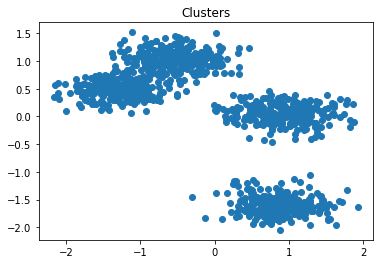

In [19]:
#data set generator
k=4
n_samples=1000
features=3

# define dataset
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

X, _ = make_blobs(n_samples, centers=k, n_features=features, cluster_std=0.6, random_state=0)

scaler = StandardScaler().fit(X)
X=scaler.transform(X)
#X=scaler.inverse_transform(X)

yhat=np.zeros(n_samples)
    
draw(X,yhat)

#### <font color = 'E3A440'>3.3.1. k-means</font>
L'application d'un algorithme de <font color='E3A440'>**segmentation**</font> à une base de données permet de segmenter les observations dans des groupes de données homogènes. Pour ce faire, l'objectif de l'algorithme est de minimiser l'inertie intra-classe :

$$ \underset{s}{\arg\min}\sum_{i=1}^{k}\frac{1}{\vert S_i\vert}\sum_\limits{x,y \in S_i}\Vert x-y \Vert^2$$

Ce type d'algorithme génère un vecteur  $Y$ de taille $n$, qui contient les <font color='E3A440'>**étiquettes des groupes**</font> qio sont assignés à chaque obeservation. Les étiquettes peuvent aller de $0$ à $k$. $k$ est le paramètre qui permet à l'usager de déterminer le nombre de groupes à générer. 

$$
Y = \begin{bmatrix} 
c_1 \\
c_2 \\
\vdots \\ 
c_n
\end{bmatrix}$$

Quindi, $Y_1$ corresponde à une étiquette donnée à $X_1$. Généralement, $k$ est le parametr;es principale d'un algorithme de segmentation et il répresente le nombre de groupes dans lesquels les données sont segmentées.

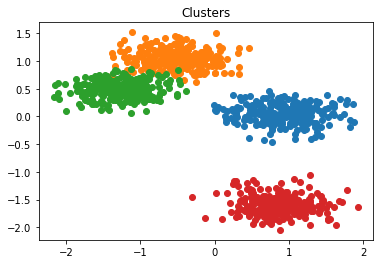

In [20]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4).fit(X)

# assign a cluster to each example
yhatkm = model.predict(X)

draw(X,yhatkm)

##### Que ce passe-t-il à chaque itération ?

Il existe plusieurs type de k-means. Toutefois, les opérations sont généralemenet similaires entre les différents version de l'aglorithme.
L'algorithme exécute les étapes suivantes: 
 1. **Initialisation des centroïdes** : des points (nombre indiqué par l'usager par le parametre *k*) sont projectés dans l'espace multidimentionel. Chaque centroïde répresente un cluster et determine l'étiquette des données qui lui sont proche.
 2. **Début des itérations**:

   2.1. **Classification**: Assigner l'étiquette aux données en tenant compte du centroïde le plus proche.

   2.2. **Déplacement des centroïdes**: pour chaque cluster généré, calculer le centre des données associées au cluster. Le centre consituitera le nouveau centroïde pour le cluster.

   2.3. **Répetition**: Répeter l'opération 2.1. et 2.2. jusqu'à que les centroïdes ne se deplacent plus.


Iteration : 1


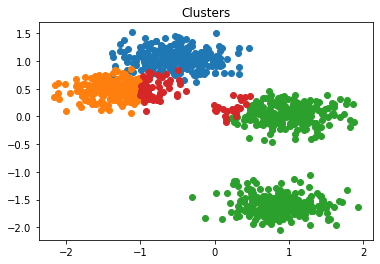

Iteration : 2


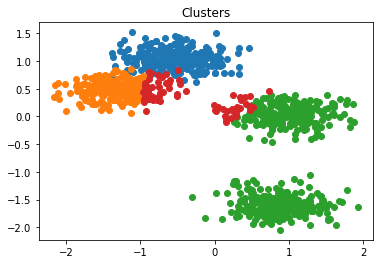

Iteration : 3


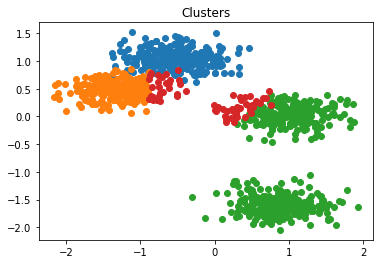

...
...
...

Iteration : 10


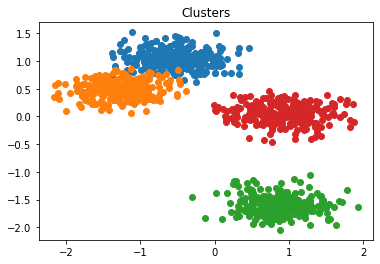

In [21]:
k=4

for i in range (1,4) :
    print("Iteration :", i)
    model = KMeans(n_clusters=k, max_iter=i, n_init=1, init="random", random_state=1).fit(X)
    # assign a cluster to each example
    yhatkm = model.predict(X)
    draw(X,yhatkm)

print("...\n...\n...\n")

i=10
print("Iteration :", i)
model = KMeans(n_clusters=k, max_iter=i, n_init=1, init="random", random_state=1).fit(X)
# assign a cluster to each example
yhatkm = model.predict(X)
draw(X,yhatkm)

##### Sensibilité à l'initialisation

La phase d'initialisation de cet algorithme est la plus délicate. En effet, différents méthodes d'initialisaiton existe et, chacun d'entre elles a un impact sur les résultats du k-means. 
L'algorithme d'initialisation le plus utilisé est le *k-means++*.

Random state : 1


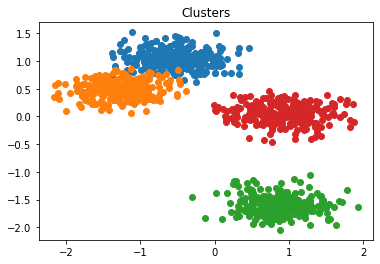

Random state : 2


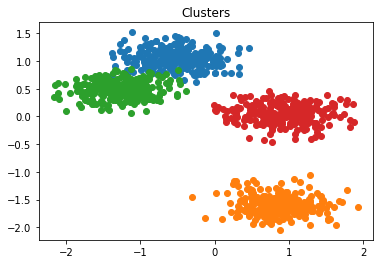

Random state : 3


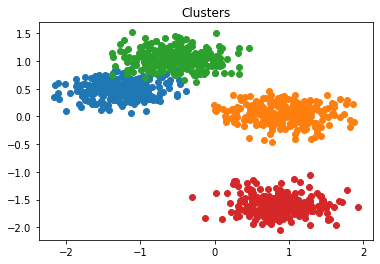

Random state : 4


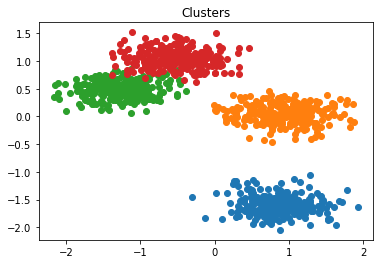

Random state : 5


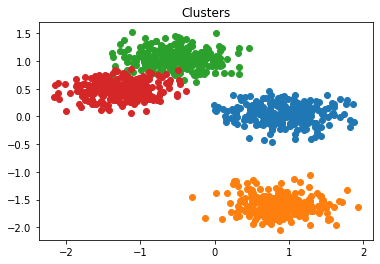

In [22]:
for rs in range (1,6) :
    print("Random state :", rs)
    model = KMeans(n_clusters=k, n_init=1, init="random", random_state=rs).fit(X)
    # assign a cluster to each example
    yhatkm = model.predict(X)
    draw(X,yhatkm)

Conclusions :

 - K-means donne un optimum LOCAL.

 - On applique la méthode avec différents points de départ et on garde le meilleur résultat.

##### Sensibilité au nombre de groupes

Le parametres *k* est le plus important et il determine les no,bre des groupes qu'on veut générer. L'algorithmer est donc très sensibl;e à ce parametre.

k =  1


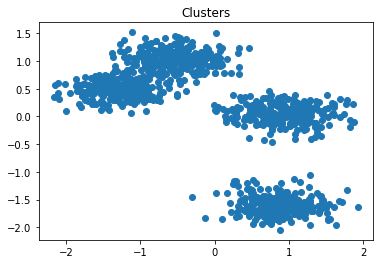

k =  2


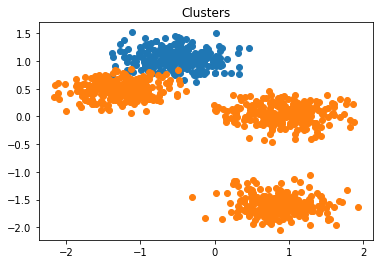

k =  3


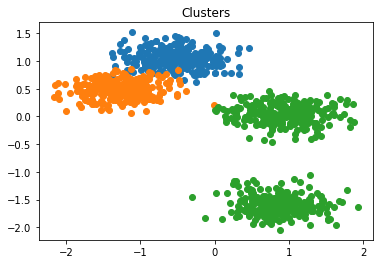

k =  4


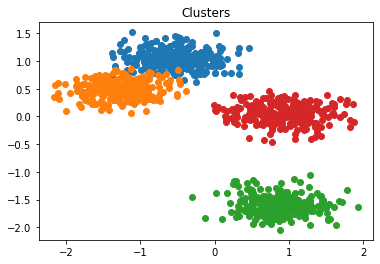

k =  5


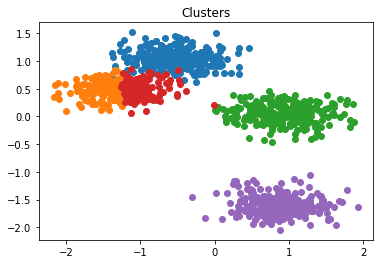

In [23]:
for m in range (1,6) :
    print("k = ", m)
    model = KMeans(n_clusters=m, max_iter=20, n_init=1, init="random", random_state=1).fit(X)
    # assign a cluster to each example
    yhatkm = model.predict(X)
    draw(X,yhatkm)

Conclusion :

  - Avec K-means il faut connaitre le nombre de groupes que l'on souhaite

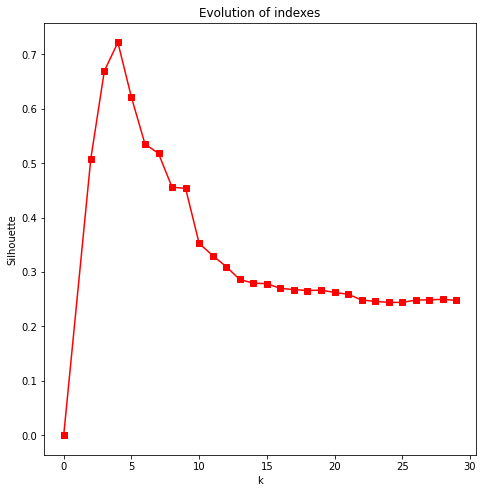

In [24]:
from sklearn.metrics import silhouette_score

max=30
Sil=np.zeros(max)
CH=np.zeros(max)
DB=np.zeros(max)
x_axis=np.zeros(max)


for m in range (2,max) :

    model = KMeans(n_clusters=m, max_iter=100, n_init=1, init="random", random_state=3).fit(X)

    # assign a cluster to each example
    labels = model.predict(X)

    Sil[m]=silhouette_score(X, labels, metric="euclidean")
    x_axis[m]=m

fig = plt.figure(figsize=(6, 6))
a1 = fig.add_axes([0,0,1,1])
l1 = a1.plot(x_axis,Sil,'rs-') # solid line with yellow colour and square marker
a1.set_xlabel('k')
a1.set_ylabel('Silhouette')
a1.set_title('Evolution of indexes')
plt.show()

##### À partir de notre ensemble de textes

In [25]:
tfidf_Matrix=tfidf_DTM.toarray()

model = KMeans(n_clusters=2).fit(tfidf_Matrix)

# assign a cluster to each example
yhatkm_tfidf = model.predict(tfidf_Matrix)

#### <font color = 'E3A440'>3.3.2. Méthode hiéarchique CHA</font>

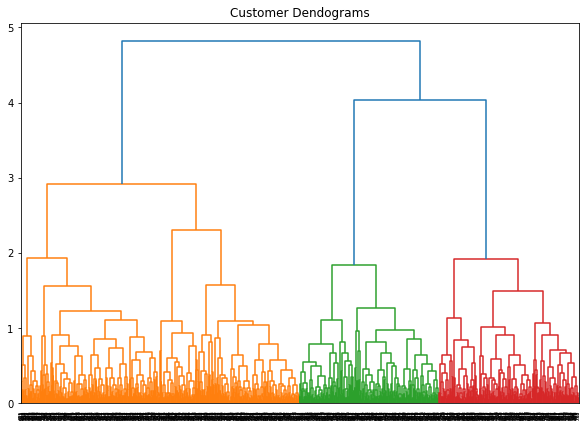

In [26]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, metric='euclidean', method='complete'))
plt.show()

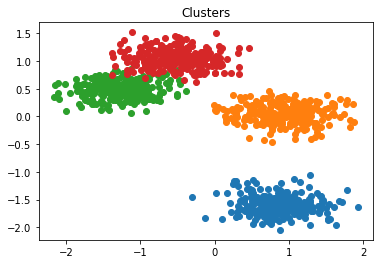

In [27]:
from sklearn.cluster import AgglomerativeClustering

model=AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete').fit(X)
#{“ward”, “complete”, “average”, “single”},

# assign a cluster to each example
yhatac=model.fit_predict(X)

draw(X,yhatac)

##### À partir de notre ensemble de textes

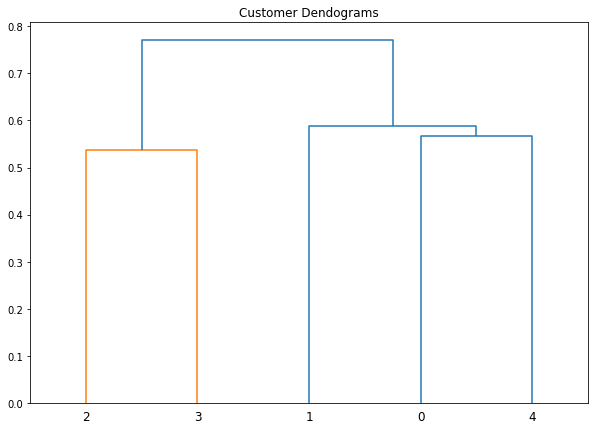

In [28]:
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(tfidf_Matrix, metric='euclidean', method='complete'))
plt.show()

#### <font color = 'E3A440'>3.3.3. DBSCAN</font>

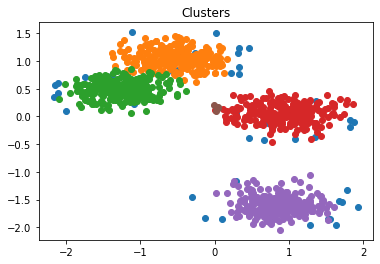

In [29]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.2, min_samples=4, metric="euclidean").fit(X)

# assign a cluster to each example
yhatdbs=model.fit_predict(X)

draw(X,yhatdbs)

#### <font color = 'E3A440'>3.3.4. Analyse du contenu des groupes</font>

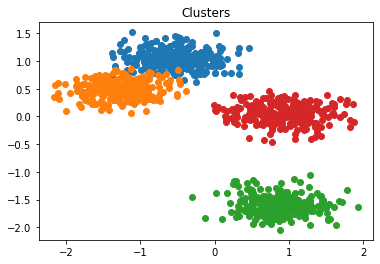

Silhouette= 0.721826710101402


In [30]:
model = KMeans(n_clusters=4, max_iter=20, n_init=1, init="random", random_state=1).fit(X)

# assign a cluster to each example
labels = model.predict(X)

draw(X,labels)

print("Silhouette=", silhouette_score(X, labels, metric="euclidean"))

In [31]:
clusters = unique(yhatkm)

for cluster in clusters:
    C = X[yhatkm[:] == cluster]
    labels=yhatkm[yhatkm[:] == cluster]
    print('Cluster %1.0f : size = %.0f' % (cluster, len(C)))

Cluster 0 : size = 250
Cluster 1 : size = 126
Cluster 2 : size = 249
Cluster 3 : size = 125
Cluster 4 : size = 250


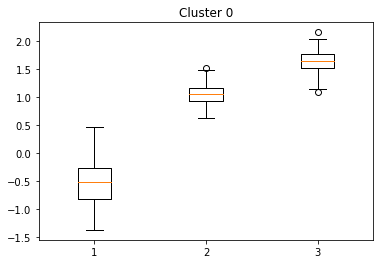

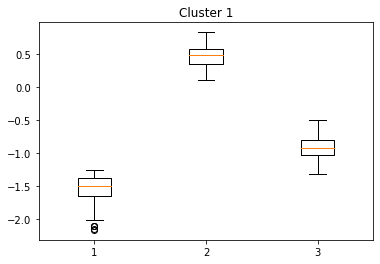

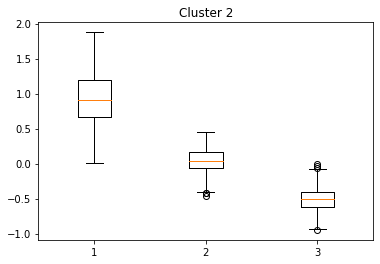

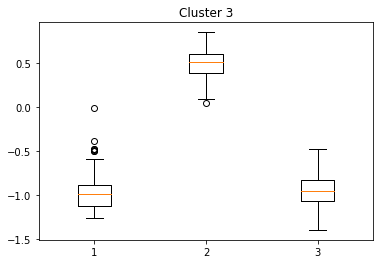

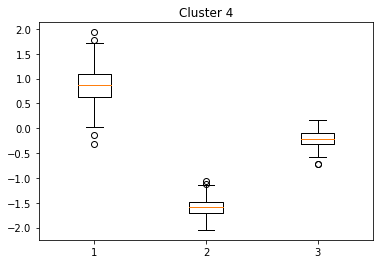

In [32]:
for cluster in clusters:
    C = X[yhatkm[:] == cluster]
    fig1, ax1 = plt.subplots()
    ax1.set_title('Cluster %1.0f' % (cluster))
    ax1.boxplot(C);

# <font color = 'E3A440'>4. Méthodes supervisées</font>


## <font color = 'E3A440'>4.1. Perceptron multicouches</font>

In [33]:
text2="""At eight o'clock, on Thursday morning, the great Arthur didn't feel VERY good.
The following morning, at nine o'clock, the great Arthur felt better.
A dog runs in the street.
In my city, cats run in the street.
A little boy runs in the street.
Arthur is my dog, we love to walk in the street together."""

In [ ]:
# Clean
sentences2 = nltk.sent_tokenize(text2)
cleaned_sentences2 = [CleaningText(sent, reduce = 'lemma', list_pos_to_keep = ['NOUN','ADJ','VERB']) for sent in sentences2]

# Calculate the tfidf matrix
freq_term_DTM2 = vectorized.fit_transform([[w for w, pos in sent] for sent in cleaned_sentences2])
tfidf = TfidfTransformer(norm='l1')
tfidf_DTM2 = tfidf.fit_transform(freq_term_DTM2)

# convert in Dataframe for pedagogical reason
tfidf_Matrix2 = pd.DataFrame(tfidf_DTM2.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
tfidf_Array2 = tfidf_DTM2.toarray()
print(tfidf_Matrix2)


In [35]:
from sklearn.neural_network import MLPClassifier

#split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) 

X_train, X_test = tfidf_Array2[:5,:], tfidf_Array2[5:,:]
y_train, y_test = [1,1,2,2,2],[2]

In [36]:
clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=10, learning_rate="constant", learning_rate_init=0.01)
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=10, learning_rate_init=0.01, max_iter=300,
              random_state=1)

In [37]:
y_valid=clf.predict(X_train)

In [38]:
y_pred=clf.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score

y_valid=clf.predict(X_train)
y_pred=clf.predict(X_test)

print("Learning errors")
print("    Accurary = ", accuracy_score(y_train, y_valid))

print("\nPrediction errors")
print("    Accurary = ", accuracy_score(y_test, y_pred))

Learning errors
    Accurary =  1.0

Prediction errors
    Accurary =  1.0


In [40]:
from sklearn.metrics import confusion_matrix

print("\n** Learning performances: **") 
print("Confusion Matrix: ") 
print(confusion_matrix(y_train, y_valid))
print ("Accuracy : ", accuracy_score(y_train, y_valid)*100) 
print("** Prediction performances: **") 
print("Confusion Matrix: ") 
print(confusion_matrix(y_test, y_pred))
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 


** Learning performances: **
Confusion Matrix: 
[[2 0]
 [0 3]]
Accuracy :  100.0
** Prediction performances: **
Confusion Matrix: 
[[1]]
Accuracy :  100.0


# <font color = 'E3A440'>5. Exercice : Analyse de commantaires blogs</font>


La base de données `20 Newsgroups` est une collection d'environ 20,000 documents segmentés en plus ou moins 20 thèmatiques différentes.

Les données sont téléchargées à partir du module `sklearn.datasets` et sont reorganisées en format tabulaire. Pour des raisons pédagogiques, cet exercice prévoit l'utilisation d'un échantillon d'environt 3,000 documents segmentées en 3 groupes difféerents : 
 1. `rec.autos`
 2. `rec.sport.hockey`
 3. `sci.med`

Pendant l'exercice, le participant sera invité à remplir les parties manquantes du code qui sont indiquées avec `...` (trois points).

In [64]:
from sklearn.datasets import fetch_20newsgroups

In [72]:
archive20newsgroup = fetch_20newsgroups(subset = 'all')
df = pd.DataFrame({'Text': archive20newsgroup.data, 'target': archive20newsgroup.target})
target_names = archive20newsgroup.target_names
print(target_names)
# subset selection
target_selected = [7,10,13]
df = df[df.target.isin(target_selected)]
target_names = [x for idx, x in enumerate(target_names) if idx in target_selected]
print(target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
['rec.autos', 'rec.sport.hockey', 'sci.med']


La base de données est composée de 2,979 documents, segementés en 3 thématiques.

In [46]:
df.shape

(2979, 2)

Voici les noms de variables disponibles.

In [73]:
df.columns

Index(['Text', 'target'], dtype='object')

Voici une observation (une ligne du tableau de données):

In [48]:
df.iloc[0].Text

"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

## <font color = 'E3A440'>5.1 Présentation de l'exercice </font>

L'éxercise est composé de deux parties:

 1. Remplir les partie de code manquant (qui sont indiqués avec les `...`
 2. Changer les parametres du prétraitement puor experimenter les impacts qui peuvent avoir sur les classifications non supervisées et supervisées. en particulier, vous êtes invités à experimenter les suivants opéraitons:

    2.1. Choisir une sélection de POS tag différents (fonction `CleaningText()`)

    2.2. Changer la seuil de fréquence minimal pour retenir un mot dans la matrice (fonction `CountVectorizer()`)

    2.3 Ajouter des bigrams et trigrams lors de la vectorisaiton (fonction `CountVectorizer()`)

Si vous voulez aller plus loins, vous pourriez aussi changer les parametres des algorithmne non supervisé et supervisé pour aanlyser les impact sur les résultats. 


Construction de certaines fonctions qui servirons plus tard.

In [74]:
def plot_data_by_cluster(DTM, cls_kmeans, figsize = (16,10) ):
    ## Reduction of dimension to 2 for visualisation reasons
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import time
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000,metric='cosine', learning_rate=10, random_state = 794)
    reduc_dim_results = tsne.fit_transform(DTM)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    ## Create data structure for plotting
    df_reduction = pd.DataFrame()
    df_reduction['y'] =  cls_kmeans.labels_
    df_reduction['1-dim'] = reduc_dim_results[:,0]
    df_reduction['2-dim'] = reduc_dim_results[:,1]

    ## Generate the plot
    import seaborn as sns
    import colorcet as cc
    plt.figure(figsize = figsize)
    sns.scatterplot(data = df_reduction,
                    x="1-dim",
                    y="2-dim",
                    hue="y",
                    palette = sns.color_palette(cc.glasbey, n_colors = cls_kmeans.n_clusters),)

    plt.show()

def prepare_data_for_WC(DTM, vocabulary_dtm):
    import scipy
    # compute total frequency for each word
    values_words = sum(DTM)
    # values_words = sum(tfidf_matrix)
    # verify type result and prepare data for wordcloud
    if type(values_words) is np.ndarray:
        values_words = [float(value) for value in np.nditer(values_words)]
    elif type(values_words) is scipy.sparse.csr.csr_matrix:
        values_words = [float(value) for value in np.nditer(values_words.todense())]
    else:
        print("Matrix in argument DTM has to be one of these two data classes:  'scipy.sparse.csr.csr_matrix' or 'numpy.ndarray'")
    ##Retrieve the word fromthe vocaboulary and sorting them based on the frequency
    list_mots = sorted(vocabulary_dtm.items(), key= lambda x:x[1])
    list_mots = [word for (word,idx) in  list_mots]
    words = zip(list_mots, values_words)
    words = sorted(words, key= lambda x:x[1], reverse=True)
    ## prepare data structure for wordcloud
    result_for_WC = {}
    #iterating over the tuples lists
    for (key, value) in words:
        result_for_WC[key] = value
    #
    return result_for_WC


def wordcloud_par_cluster(wordcloud, DTM, cls_kmeans, vocab, first_n_words=10, figsize=(18, 16), fontsize=32, plot_wordcloud = True, lst_clust = [], title_in_plot = "Clust_"):

        """
        wordcloud; A WordCloud function.
        DTM; A Docuemnt-Term Matrix
        vocab; It is a vocabulary from skllarn vectorizer
        first_n_words = 10; How many words to print
        figsize = (18, 16); Size of the plot. (this is the argument of this line plt.figure(figsize=figsize))
        fontsize = 32; Size of title font
        lst_clust = []; The list of cluster to plot. If empty, all the clusters are plotted
        title_in_plot = "Clust_"; title to put on top of plot \n
        """
        import numpy
        import scipy
        
        if not lst_clust:
            lst_clust = list(range(cls_kmeans.n_clusters))

        for x in lst_clust:
            DTM_temp = DTM[cls_kmeans.labels_ == x]
            result_for_WC= prepare_data_for_WC(DTM_temp, vocab)
            ###
            if plot_wordcloud == True:
                plot = wordcloud.generate_from_frequencies(result_for_WC)
                plt.figure(figsize=figsize)
                plt.imshow(plot)
                plt.title(title_in_plot + str(x) + '  N. of documents=' + str(DTM_temp.shape[0]),
                        fontsize = fontsize,
                        bbox=dict(facecolor='red', alpha=0.5))
                plt.axis('off')
                plt.show()
            print(f"Most frequent words for cluster {x} of size {str(DTM_temp.shape[0])} docs: ", list(result_for_WC)[0:first_n_words])

### <font color = 'E3A440'> b. Annotation, nettoyage et vectorisation des tweets (Rappels)</font>

Nous utilisons la fonction écrite précédemment pour nettoyer les unités lexicales de tweets. Pour ce premier test, nous conservons seulement les adjectifs.

Cette opération prendra quelques secondes. 

In [75]:
cleaned_20news = [CleaningText(sent, reduce = 'lemma', list_pos_to_keep = [...], Stopwords_to_add=['http','following']) for sent in list(df['Text'])]

Dans l'étape de vectorisation, nous retenons les mots qui apparaissent dans au moins 5 documents (min_df = 5).

In [79]:
# Initialisation de l'objet
def identity_tokenizer(text):
    return text
# Transforming the word in frequencies
vectorized = CountVectorizer(lowercase = False, # Convert all characters to lowercase before tokenizing
                             min_df = ..., # Ignore terms that have a document frequency strictly lower than the given threshold 
                             max_df = 1200, # Ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)
                             stop_words = stopwords.words('english'), # Remove the list of words provided
                             ngram_range = (1, 3), # Get the lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted
                             tokenizer=identity_tokenizer) # Override the string tokenization step while preserving the preprocessing and n-grams generation steps

In [80]:
freq_term_DTM_papers = vectorized.fit_transform([[w for w, pos in sent if len(w) > 2] for sent in cleaned_20news])
freq_term_DTM_papers

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


<2979x3469 sparse matrix of type '<class 'numpy.int64'>'
	with 157061 stored elements in Compressed Sparse Row format>

In [ ]:
# Calculate the tfidf matrix
tfidf = TfidfTransformer(norm='l1')
tfidf_DTM_papers = tfidf.fit_transform(freq_term_DTM_papers)
#print(tfidf_DTM)

tfidf_DF_papers = pd.DataFrame(tfidf_DTM_papers.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
print(tfidf_DF_papers)

## <font color = 'E3A440'>5.2 Question non supervisé </font>

1. Séparer les tweets en groupes homogènes en utilisant un clustering


Évaluer la meilleure partition

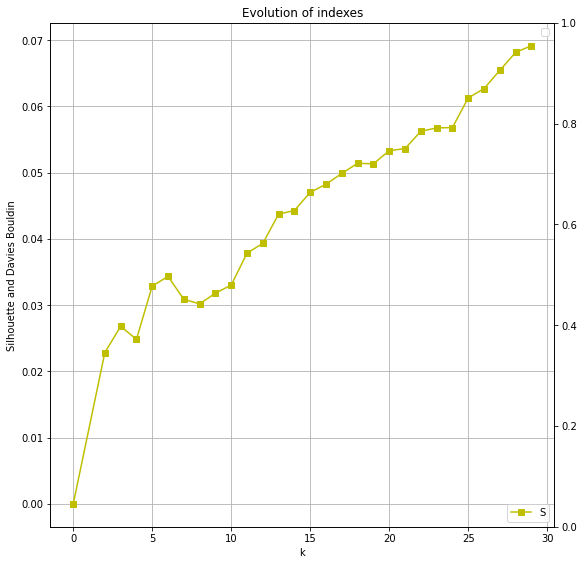

In [85]:
max=30
Sil=np.zeros(max)
CH=np.zeros(max)
DB=np.zeros(max)
x_axis=np.zeros(max)

tfidf_DTM_papers_norm = Normalizer().transform(tfidf_DTM_papers)

for m in range (2,max) :

    model = KMeans(n_clusters=m, max_iter=100, n_init=1, init="k-means++", random_state=3).fit(tfidf_DTM_papers_norm)

    # assign a cluster to each example
    labels = model.predict(tfidf_DTM_papers_norm)

    Sil[m]=silhouette_score(tfidf_DTM_papers_norm, labels, metric="cosine")
    x_axis[m]=m

fig = plt.figure(figsize=(7, 7))
a1 = fig.add_axes([0,0,1,1])
a2 = a1.twinx()
l1 = a1.plot(x_axis,Sil,'ys-') # solid line with yellow colour and square marker
a1.legend(labels = 'Silhouette', loc = 'lower right') # legend placed at lower right
a2.legend(loc=0)
a1.set_xlabel('k')
a1.set_ylabel('Silhouette and Davies Bouldin')
#a2.set_ylabel('Calinski Harabasz')
a1.set_title('Evolution of indexes')
a1.yaxis.grid(True)
a1.xaxis.grid(True)
plt.show()

Ajouter le bon numéro de cluster à génèrer en substituant les trois points `...`

In [86]:
tfidf_DTM_papers_norm = Normalizer().transform(tfidf_DTM_papers.toarray())
model = KMeans(n_clusters = ..., max_iter=200, n_init=1, init="k-means++", random_state=1).fit(tfidf_DTM_papers_norm)
# assign a cluster to each example
labels = model.predict(tfidf_DTM_papers_norm)

print("Silhouette=", silhouette_score(tfidf_DTM_papers_norm, labels, metric="cosine"))

Silhouette= 0.024311116852286825


In [87]:
model.n_clusters

3

In [88]:
Counter(model.labels_)

Counter({1: 887, 2: 1254, 0: 838})

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2979 samples in 0.013s...
[t-SNE] Computed neighbors for 2979 samples in 1.501s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2979
[t-SNE] Computed conditional probabilities for sample 2000 / 2979
[t-SNE] Computed conditional probabilities for sample 2979 / 2979
[t-SNE] Mean sigma: 0.291995
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.317993
[t-SNE] KL divergence after 1000 iterations: 1.622807
t-SNE done! Time elapsed: 21.888909816741943 seconds


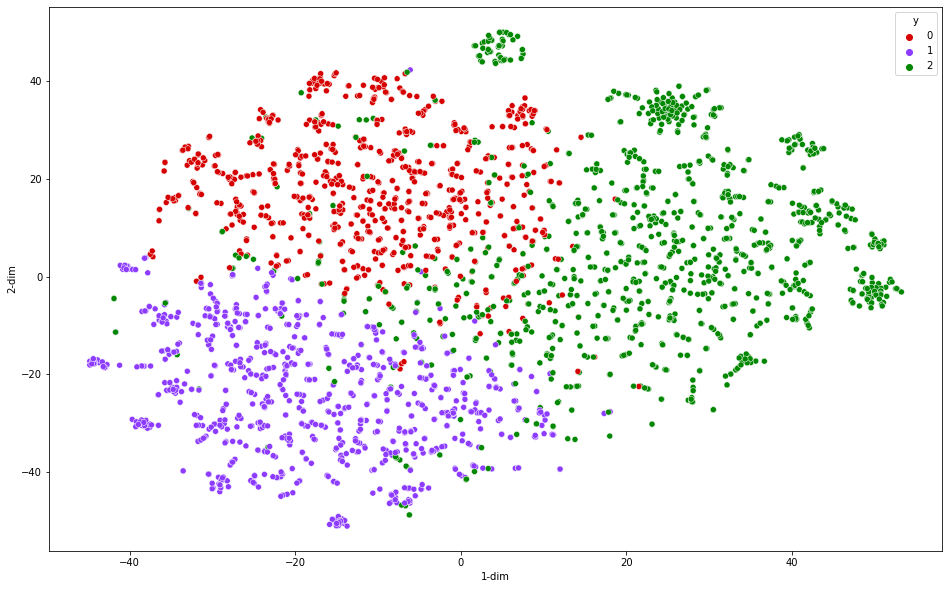

In [57]:
plot_data_by_cluster(tfidf_DTM_papers_norm, model )

In [89]:
from wordcloud import WordCloud
wordcloud_par_cluster(wordcloud = WordCloud(), # WordCloud function. 
                      DTM = tfidf_DTM_papers_norm,# Document-Term Matrix 
                      cls_kmeans = model, # Insert the result of a kmeans clustering
                      vocab = vectorized.vocabulary_, # a vocabulary from scikitlearn vectorizer
                      first_n_words=10,#  It indicates how many words to print
                      figsize=(12, 10),
                      fontsize=32,
                      plot_wordcloud = False, # Switch to True if you want to plot wordclouds
                      lst_clust = [], # Insert a list of integer to get info about a selected number of cluster. It shows info of all the clustrs if empty list
                      title_in_plot = "Clust_")

Most frequent words for cluster 0 of size 838 docs:  ['car', 'engine', 'oil', 'dealer', 'ford', 'new', 'usa', 'distribution', 'price', 'good']
Most frequent words for cluster 1 of size 887 docs:  ['game', 'team', 'hockey', 'player', 'espn', 'playoff', 'nhl', 'fan', 'year', 'goal']
Most frequent words for cluster 2 of size 1254 docs:  ['doctor', 'msg', 'bank', 'gordon', 'gordon bank', 'people', 'food', 'disease', 'medical', 'geb']


In [90]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
df['target_converted'] = df.target
df['target_converted'] = df.target_converted.apply(lambda x: 0 if x == 7 else x)
df['target_converted'] = df.target_converted.apply(lambda x: 1 if x == 10 else x)
df['target_converted'] = df.target_converted.apply(lambda x: 2 if x == 13 else x)
print(accuracy_score(df.target_converted, model.labels_))

0.9103726082578046


## <font color = 'E3A440'>5.3 Question supervisé </font>

Classifier abstract with previous clustering

In [91]:
from sklearn.model_selection import train_test_split
tfidf_DTM_papers_norm = Normalizer().transform(tfidf_DTM_papers)
X_train, X_test, y_train, y_test = train_test_split(tfidf_DTM_papers_norm, df.target, test_size = 0.2,  random_state=1)

In [92]:
print(X_train.shape)
print(len(y_train))

(2383, 3469)
2383


In [93]:
print(X_test.shape)
print(len(y_test))

(596, 3469)
596


In [94]:
cls = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [95]:
y_pred = cls.predict(X_test)

In [96]:
cls.score(X_test, y_test)

0.9848993288590604

In [97]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.9849326213852287

## <font color = 'E3A440'> 2.3 NOTES PERSONNELLES: </font>

-----

-----